In [37]:
import nltk, re
import os
import gensim
import pickle
import pandas as pd
import numpy as np
import gensim.downloader as api
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from functools import reduce
from operator import add, itemgetter
from glob import glob
from pprint import pprint
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from copy import deepcopy
from utils import video_id_without_categories


wv = api.load('word2vec-google-news-300')

# Ground Truth

In [2]:
with open('data/category_id.pkl', 'rb') as fh:
    data = pickle.load(fh)

In [3]:
idx = [[(item['id'], int(item['snippet']['categoryId'])) for item in batch['items']] for batch in data]
idx = reduce(add, idx, [])

In [4]:
len(idx)

5212

In [5]:
df = pd.read_pickle('data/chkp2.pkl')
unknown_idx = video_id_without_categories(df)
unknown_idx.shape

(5768,)

In [6]:
list(set(unknown_idx) - set(map(itemgetter(0),idx)))[:5]

['Wlnt6VrVUgc', 'l2P2qbr-_Ps', 'NDBwsMIXlMk', 'If3NqScFjg0', 'kKk6vEqFFOA']

In [7]:
# Niedostępne filmy
len(set(unknown_idx) - set(map(itemgetter(0),idx)))

556

In [8]:
kaggle_df =  pd.concat([
    pd.read_csv(path, usecols=['video_id', 'category_id']) for path in glob('data/kaggle/*.csv')
]).groupby('video_id').max()

In [9]:
category_df = pd.DataFrame(np.array(idx), columns=['video_id', 'category_id']).set_index('video_id')
category_df = pd.concat([category_df, kaggle_df.loc[list(set(unknown_idx) - set(map(itemgetter(0),idx))), :]])
category_df['category_id'] = category_df.category_id.astype(int)
category_df

,category_id
video_id,
9wRQljFNDW8,17
Om_zGhJLZ5U,1
goP4Z5wyOlM,25
8NHA23f7LvU,24
IE-xepGLVt8,28
...,...
p7KHGUwqF24,25
RNA516fNpuw,17
NqfJ9wIWX4E,24


# Wszystkie cechy

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8606 entries, 9wRQljFNDW8 to 4YFo4bdMO8Q
Columns: 123 entries, trending_date to iqr_blue
dtypes: bool(5), datetime64[ns, UTC](1), datetime64[ns](3), float32(1), float64(45), int64(47), object(19), timedelta64[ns](2)
memory usage: 7.8+ MB


In [11]:
# for dtype in set(df.dtypes):
#     cols = list(df.columns[np.where(df.dtypes == dtype)])
#     print(f" --- Typ: {dtype} --- ")
#     pprint(cols)
#     print()

In [12]:
pd.options.display.max_columns = 1000
df.head(3)

,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,origin,category_id,category_text,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_date_end,trending_date_start,trending_span,trending_span_days,publish_to_trending_span,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,description_embedding,title_embedding,channel_title_hash,is_us,is_gb,feature_vector,people_amount,objects,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,hist_reds,hist_greens,hist_blues,fisher_vector,face_count,emotions,count_angry,count_sad,count_neutral,count_disgust,count_surprise,count_fear,count_happy,image_text,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,2017-11-14,Dion Lewis' 103-Yd Kick Return TD vs. Denver! ...,NFL,2017-11-13 02:05:26+00:00,"NFL|""Football""|""offense""|""defense""|""afc""|""nfc""...",81377,655,25,177,https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg,False,False,False,New England Patriots returner Dion Lewis blast...,US,NaN,NaN,13,11,2017,0,4,2,5,26,14,11,2017,1,4,2017-11-14,2017-11-14,0 days,0,0 days 21:54:34,21,655,655,0,25,25,0,81377,81377,0,177,177,0,680,0.963235,0.036765,680,0.963235,0.036765,8,127,0,1,3,0,86,1255,3,58,963,3,0.674419,0.767331,1.000000,0.017241,0.003115,0.0,15,177.0,1,16.0,0.090395,0.275862,0.096573,1.000000,"[0.1286950558423996, 0.09136795997619629, -0.0...","[0.06370916962623596, 0.06371407955884933, -0....",-3.467289e+10,True,False,"[0.06580926, -0.12843476, -0.04167219, -0.0986...",8.0,"[person, person, person, person, person, perso...","(person, 0.5387666)",person,12.542644,-143.0,48.0,8008.0,134508.0,150069.0,157884.0,161032.0,165137.0,172800.0,"[0.23528356481481483, 0.016064814814814816, 0....","[0.2470138888888889, 0.023055555555555555, 0.0...","[0.2572511574074074, 0.01494212962962963, 0.01...","[-1.3669241025582595, 1.6668570796367268, 1.89...",0.0,[],0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[brood, cantmiss, playe, lewis, yard, return, ...",84.459803,79.0,134.0,52.581076,38.0,72.0,44.219300,22.0,56.0
Om_zGhJLZ5U,2017-11-14,TL;DW - Every DCEU Movie Before Justice League,Screen Junkies,2017-11-12 18:00:03+00:00,"screenjunkies|""screen junkies""|""sj news""|""hone...",288922,7515,792,2111,https://i.ytimg.com/vi/Om_zGhJLZ5U/default.jpg,False,False,False,With Justice League approaching fast we rewatc...,US,NaN,NaN,12,11,2017,6,4,18,0,3,14,11,2017,1,4,2017-11-14,2017-11-14,0 days,0,1 days 05:59:57,29,7515,7515,0,792,792,0,288922,288922,0,2111,2111,0,8307,0.904659,0.095341,8307,0.904659,0.095341,2,23,0,0,3,0,46,396,14,37,311,13,0.804348,0.785354,0.928571,0.00

In [13]:
to_int = ['comments_disabled', 'ratings_disabled', 'video_error_or_removed', 'is_us', 'is_gb']
df[to_int] = df[to_int].astype(int)
df.head(3)

,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,origin,category_id,category_text,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_date_end,trending_date_start,trending_span,trending_span_days,publish_to_trending_span,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,description_embedding,title_embedding,channel_title_hash,is_us,is_gb,feature_vector,people_amount,objects,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,hist_reds,hist_greens,hist_blues,fisher_vector,face_count,emotions,count_angry,count_sad,count_neutral,count_disgust,count_surprise,count_fear,count_happy,image_text,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,2017-11-14,Dion Lewis' 103-Yd Kick Return TD vs. Denver! ...,NFL,2017-11-13 02:05:26+00:00,"NFL|""Football""|""offense""|""defense""|""afc""|""nfc""...",81377,655,25,177,https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg,0,0,0,New England Patriots returner Dion Lewis blast...,US,NaN,NaN,13,11,2017,0,4,2,5,26,14,11,2017,1,4,2017-11-14,2017-11-14,0 days,0,0 days 21:54:34,21,655,655,0,25,25,0,81377,81377,0,177,177,0,680,0.963235,0.036765,680,0.963235,0.036765,8,127,0,1,3,0,86,1255,3,58,963,3,0.674419,0.767331,1.000000,0.017241,0.003115,0.0,15,177.0,1,16.0,0.090395,0.275862,0.096573,1.000000,"[0.1286950558423996, 0.09136795997619629, -0.0...","[0.06370916962623596, 0.06371407955884933, -0....",-3.467289e+10,1,0,"[0.06580926, -0.12843476, -0.04167219, -0.0986...",8.0,"[person, person, person, person, person, perso...","(person, 0.5387666)",person,12.542644,-143.0,48.0,8008.0,134508.0,150069.0,157884.0,161032.0,165137.0,172800.0,"[0.23528356481481483, 0.016064814814814816, 0....","[0.2470138888888889, 0.023055555555555555, 0.0...","[0.2572511574074074, 0.01494212962962963, 0.01...","[-1.3669241025582595, 1.6668570796367268, 1.89...",0.0,[],0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[brood, cantmiss, playe, lewis, yard, return, ...",84.459803,79.0,134.0,52.581076,38.0,72.0,44.219300,22.0,56.0
Om_zGhJLZ5U,2017-11-14,TL;DW - Every DCEU Movie Before Justice League,Screen Junkies,2017-11-12 18:00:03+00:00,"screenjunkies|""screen junkies""|""sj news""|""hone...",288922,7515,792,2111,https://i.ytimg.com/vi/Om_zGhJLZ5U/default.jpg,0,0,0,With Justice League approaching fast we rewatc...,US,NaN,NaN,12,11,2017,6,4,18,0,3,14,11,2017,1,4,2017-11-14,2017-11-14,0 days,0,1 days 05:59:57,29,7515,7515,0,792,792,0,288922,288922,0,2111,2111,0,8307,0.904659,0.095341,8307,0.904659,0.095341,2,23,0,0,3,0,46,396,14,37,311,13,0.804348,0.785354,0.928571,0.000000,0.009646,0.0,9,61.0,2,4.0,

In [14]:
to_ingore = ['trending_date', 'title', 'channel_title', 'publish_time', 'thumbnail_link', 
             'description', 'origin', 'trending_date_end', 'trending_date_start', 'trending_span', 'publish_to_trending_span',
             'emotions']

df.drop(to_ingore, axis=1, inplace=True)
df.head(3)

,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,category_id,category_text,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_span_days,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,description_embedding,title_embedding,channel_title_hash,is_us,is_gb,feature_vector,people_amount,objects,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,hist_reds,hist_greens,hist_blues,fisher_vector,face_count,count_angry,count_sad,count_neutral,count_disgust,count_surprise,count_fear,count_happy,image_text,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,"NFL|""Football""|""offense""|""defense""|""afc""|""nfc""...",81377,655,25,177,0,0,0,NaN,NaN,13,11,2017,0,4,2,5,26,14,11,2017,1,4,0,21,655,655,0,25,25,0,81377,81377,0,177,177,0,680,0.963235,0.036765,680,0.963235,0.036765,8,127,0,1,3,0,86,1255,3,58,963,3,0.674419,0.767331,1.000000,0.017241,0.003115,0.0,15,177.0,1,16.0,0.090395,0.275862,0.096573,1.000000,"[0.1286950558423996, 0.09136795997619629, -0.0...","[0.06370916962623596, 0.06371407955884933, -0....",-3.467289e+10,1,0,"[0.06580926, -0.12843476, -0.04167219, -0.0986...",8.0,"[person, person, person, person, person, perso...","(person, 0.5387666)",person,12.542644,-143.0,48.0,8008.0,134508.0,150069.0,157884.0,161032.0,165137.0,172800.0,"[0.23528356481481483, 0.016064814814814816, 0....","[0.2470138888888889, 0.023055555555555555, 0.0...","[0.2572511574074074, 0.01494212962962963, 0.01...","[-1.3669241025582595, 1.6668570796367268, 1.89...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[brood, cantmiss, playe, lewis, yard, return, ...",84.459803,79.0,134.0,52.581076,38.0,72.0,44.219300,22.0,56.0
Om_zGhJLZ5U,"screenjunkies|""screen junkies""|""sj news""|""hone...",288922,7515,792,2111,0,0,0,NaN,NaN,12,11,2017,6,4,18,0,3,14,11,2017,1,4,0,29,7515,7515,0,792,792,0,288922,288922,0,2111,2111,0,8307,0.904659,0.095341,8307,0.904659,0.095341,2,23,0,0,3,0,46,396,14,37,311,13,0.804348,0.785354,0.928571,0.000000,0.009646,0.0,9,61.0,2,4.0,0.065574,0.351351,0.070740,0.153846,"[0.08945216238498688, 0.012981911189854145, 0....","[0.10034792870283127, 0.018092168495059013, -0...",-2.138384e+10,1,0,"[0.00328945, -0.09353591, 0.4361128, -0.185314...",3.0,"[person, person, person]","(person, 0.87004745)",person,11.607859,-228.0,46.0,3130.0,27840.0,47628.0,88412.0,172800.0,172800.0,172800.0,"[0.23725694444444445, 0.015381944444444445, 0....","[0.23922453703703703, 0.015578703703703704, 0....","[0.2574768518518519, 0.01732060185185185, 0.01...","[-1.6507262497608926, 1.7259565315033054, 1.74...",2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,"[tlsdw, scteen, long, didnt, watch, junkies]",68.507153,31.0,114.0,66.

### Embed the rest of categorical columns

In [15]:
text_to_process = ['image_text', 'tags', 'objects']

# Preprocess tags
stopwords_list = list(stopwords.words('english'))
def preprocess_tags(sentence):
    wordtokens = word_tokenize(re.sub('[^A-Za-z]+', ' ', sentence.lower()))
    wordtokens = [word for word in wordtokens if (word not in stopwords_list) and (len(word) > 2) and not (word.isnumeric())]
    return wordtokens

df['tags'] = df['tags'].apply(preprocess_tags)

df[text_to_process].head(3)

,image_text,tags,objects
video_id,,,
9wRQljFNDW8,"[brood, cantmiss, playe, lewis, yard, return, ...","[nfl, football, offense, defense, afc, nfc, am...","[person, person, person, person, person, perso..."
Om_zGhJLZ5U,"[tlsdw, scteen, long, didnt, watch, junkies]","[screenjunkies, screen, junkies, news, honest,...","[person, person, person]"
goP4Z5wyOlM,"[tehran, ahalabja, iraq, baghdad, iran, news]","[bbc, bbc, news, news, iran, iran, news, iraq,...",[]


In [16]:
df_temp = deepcopy(df[text_to_process])

def word_averaging(wv, sequence):
    mean = []
    try:
        for word in sequence:
            if word in wv.key_to_index:
                mean.append(wv.get_vector(word))
    except:
        return np.zeros(300,)
    if not mean: return np.zeros(300,)
    return gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)

def word_averaging_list(wv, sequences):
    return np.vstack([word_averaging(wv, w) for w in sequences])

def embedding_model(text, name):
    # Word averaging
    wa = word_averaging_list(wv, text)
    # Replace cols
    df_temp[name] = list(wa)

for col in text_to_process:
    embedding_model(df_temp[col].values, col)

df[text_to_process] = df_temp

df.head(3)

,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,category_id,category_text,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_span_days,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,description_embedding,title_embedding,channel_title_hash,is_us,is_gb,feature_vector,people_amount,objects,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,hist_reds,hist_greens,hist_blues,fisher_vector,face_count,count_angry,count_sad,count_neutral,count_disgust,count_surprise,count_fear,count_happy,image_text,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",81377,655,25,177,0,0,0,NaN,NaN,13,11,2017,0,4,2,5,26,14,11,2017,1,4,0,21,655,655,0,25,25,0,81377,81377,0,177,177,0,680,0.963235,0.036765,680,0.963235,0.036765,8,127,0,1,3,0,86,1255,3,58,963,3,0.674419,0.767331,1.000000,0.017241,0.003115,0.0,15,177.0,1,16.0,0.090395,0.275862,0.096573,1.000000,"[0.1286950558423996, 0.09136795997619629, -0.0...","[0.06370916962623596, 0.06371407955884933, -0....",-3.467289e+10,1,0,"[0.06580926, -0.12843476, -0.04167219, -0.0986...",8.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(person, 0.5387666)",person,12.542644,-143.0,48.0,8008.0,134508.0,150069.0,157884.0,161032.0,165137.0,172800.0,"[0.23528356481481483, 0.016064814814814816, 0....","[0.2470138888888889, 0.023055555555555555, 0.0...","[0.2572511574074074, 0.01494212962962963, 0.01...","[-1.3669241025582595, 1.6668570796367268, 1.89...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",84.459803,79.0,134.0,52.581076,38.0,72.0,44.219300,22.0,56.0
Om_zGhJLZ5U,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",288922,7515,792,2111,0,0,0,NaN,NaN,12,11,2017,6,4,18,0,3,14,11,2017,1,4,0,29,7515,7515,0,792,792,0,288922,288922,0,2111,2111,0,8307,0.904659,0.095341,8307,0.904659,0.095341,2,23,0,0,3,0,46,396,14,37,311,13,0.804348,0.785354,0.928571,0.000000,0.009646,0.0,9,61.0,2,4.0,0.065574,0.351351,0.070740,0.153846,"[0.08945216238498688, 0.012981911189854145, 0....","[0.10034792870283127, 0.018092168495059013, -0...",-2.138384e+10,1,0,"[0.00328945, -0.09353591, 0.4361128, -0.185314...",3.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(person, 0.87004745)",person,11.607859,-228.0,46.0,3130.0,27840.0,47628.0,88412.0,172800.0,172800.0,172800.0,"[0.23725694444444445, 0.015381944444444445, 0....","[0.23922453703703703, 0.015578703703703704, 0....","[0.2574768518518519, 0.01732060185185185, 0.01...","[-1.6507262497608926, 1.7259565315033054, 1.74...",2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",68.507153

### Other

In [17]:
to_encode = ['most_occurence_object']
df[to_encode] = LabelEncoder().fit_transform(df[to_encode].values.ravel())
df.head(3)

,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,category_id,category_text,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_span_days,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,description_embedding,title_embedding,channel_title_hash,is_us,is_gb,feature_vector,people_amount,objects,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,hist_reds,hist_greens,hist_blues,fisher_vector,face_count,count_angry,count_sad,count_neutral,count_disgust,count_surprise,count_fear,count_happy,image_text,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",81377,655,25,177,0,0,0,NaN,NaN,13,11,2017,0,4,2,5,26,14,11,2017,1,4,0,21,655,655,0,25,25,0,81377,81377,0,177,177,0,680,0.963235,0.036765,680,0.963235,0.036765,8,127,0,1,3,0,86,1255,3,58,963,3,0.674419,0.767331,1.000000,0.017241,0.003115,0.0,15,177.0,1,16.0,0.090395,0.275862,0.096573,1.000000,"[0.1286950558423996, 0.09136795997619629, -0.0...","[0.06370916962623596, 0.06371407955884933, -0....",-3.467289e+10,1,0,"[0.06580926, -0.12843476, -0.04167219, -0.0986...",8.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(person, 0.5387666)",46,12.542644,-143.0,48.0,8008.0,134508.0,150069.0,157884.0,161032.0,165137.0,172800.0,"[0.23528356481481483, 0.016064814814814816, 0....","[0.2470138888888889, 0.023055555555555555, 0.0...","[0.2572511574074074, 0.01494212962962963, 0.01...","[-1.3669241025582595, 1.6668570796367268, 1.89...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",84.459803,79.0,134.0,52.581076,38.0,72.0,44.219300,22.0,56.0
Om_zGhJLZ5U,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",288922,7515,792,2111,0,0,0,NaN,NaN,12,11,2017,6,4,18,0,3,14,11,2017,1,4,0,29,7515,7515,0,792,792,0,288922,288922,0,2111,2111,0,8307,0.904659,0.095341,8307,0.904659,0.095341,2,23,0,0,3,0,46,396,14,37,311,13,0.804348,0.785354,0.928571,0.000000,0.009646,0.0,9,61.0,2,4.0,0.065574,0.351351,0.070740,0.153846,"[0.08945216238498688, 0.012981911189854145, 0....","[0.10034792870283127, 0.018092168495059013, -0...",-2.138384e+10,1,0,"[0.00328945, -0.09353591, 0.4361128, -0.185314...",3.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(person, 0.87004745)",46,11.607859,-228.0,46.0,3130.0,27840.0,47628.0,88412.0,172800.0,172800.0,172800.0,"[0.23725694444444445, 0.015381944444444445, 0....","[0.23922453703703703, 0.015578703703703704, 0....","[0.2574768518518519, 0.01732060185185185, 0.01...","[-1.6507262497608926, 1.7259565315033054, 1.74...",2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",68.507153,31.0,11

In [18]:
to_untuple = ['max_prob_object']
df[to_untuple] = LabelEncoder().fit_transform(df[to_untuple].\
    applymap(lambda x: x[0] if isinstance(x, tuple) else 'none').fillna('none').values.ravel())
df.head(3)

,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,category_id,category_text,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_span_days,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,description_embedding,title_embedding,channel_title_hash,is_us,is_gb,feature_vector,people_amount,objects,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,hist_reds,hist_greens,hist_blues,fisher_vector,face_count,count_angry,count_sad,count_neutral,count_disgust,count_surprise,count_fear,count_happy,image_text,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",81377,655,25,177,0,0,0,NaN,NaN,13,11,2017,0,4,2,5,26,14,11,2017,1,4,0,21,655,655,0,25,25,0,81377,81377,0,177,177,0,680,0.963235,0.036765,680,0.963235,0.036765,8,127,0,1,3,0,86,1255,3,58,963,3,0.674419,0.767331,1.000000,0.017241,0.003115,0.0,15,177.0,1,16.0,0.090395,0.275862,0.096573,1.000000,"[0.1286950558423996, 0.09136795997619629, -0.0...","[0.06370916962623596, 0.06371407955884933, -0....",-3.467289e+10,1,0,"[0.06580926, -0.12843476, -0.04167219, -0.0986...",8.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",46,46,12.542644,-143.0,48.0,8008.0,134508.0,150069.0,157884.0,161032.0,165137.0,172800.0,"[0.23528356481481483, 0.016064814814814816, 0....","[0.2470138888888889, 0.023055555555555555, 0.0...","[0.2572511574074074, 0.01494212962962963, 0.01...","[-1.3669241025582595, 1.6668570796367268, 1.89...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",84.459803,79.0,134.0,52.581076,38.0,72.0,44.219300,22.0,56.0
Om_zGhJLZ5U,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",288922,7515,792,2111,0,0,0,NaN,NaN,12,11,2017,6,4,18,0,3,14,11,2017,1,4,0,29,7515,7515,0,792,792,0,288922,288922,0,2111,2111,0,8307,0.904659,0.095341,8307,0.904659,0.095341,2,23,0,0,3,0,46,396,14,37,311,13,0.804348,0.785354,0.928571,0.000000,0.009646,0.0,9,61.0,2,4.0,0.065574,0.351351,0.070740,0.153846,"[0.08945216238498688, 0.012981911189854145, 0....","[0.10034792870283127, 0.018092168495059013, -0...",-2.138384e+10,1,0,"[0.00328945, -0.09353591, 0.4361128, -0.185314...",3.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",46,46,11.607859,-228.0,46.0,3130.0,27840.0,47628.0,88412.0,172800.0,172800.0,172800.0,"[0.23725694444444445, 0.015381944444444445, 0....","[0.23922453703703703, 0.015578703703703704, 0....","[0.2574768518518519, 0.01732060185185185, 0.01...","[-1.6507262497608926, 1.7259565315033054, 1.74...",2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",68.507153,31.0,114.0,66.207436,33.0,116.0,57.418987,25.0

##### Saving final file

In [19]:
df.to_pickle("data/chkp12.pkl")

### Selection for embedding features

In [61]:
to_embeddings = ['description_embedding', 'title_embedding', 'feature_vector', 'hist_reds', 'hist_greens', 'hist_blues', 'fisher_vector']
import tqdm

embeddings_statistics = []
for col in tqdm.tqdm(to_embeddings):
    unwrapped_df = df[col].apply(lambda x: pd.Series(x, dtype='float32'))
    correlation = unwrapped_df.corrwith(df.category_id, method='spearman')
    correlation = correlation.describe()
    correlation['name'] = col
    embeddings_statistics.append(correlation)

100%|██████████| 7/7 [00:17<00:00,  2.50s/it]


<AxesSubplot:ylabel='name'>

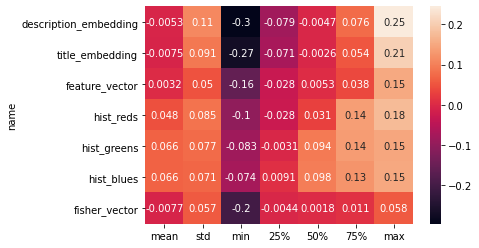

In [78]:
stats_df = pd.concat(embeddings_statistics, axis=1).T.set_index('name').astype('float32')
stats_df.drop('count', axis=1, inplace=True)
sns.heatmap(stats_df, annot=True)

### Dataset with all categories

In [21]:
df = pd.read_pickle("data/chkp12.pkl")
df.head(2)

,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,category_id,category_text,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_span_days,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,description_embedding,title_embedding,channel_title_hash,is_us,is_gb,feature_vector,people_amount,objects,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,hist_reds,hist_greens,hist_blues,fisher_vector,face_count,count_angry,count_sad,count_neutral,count_disgust,count_surprise,count_fear,count_happy,image_text,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",81377,655,25,177,0,0,0,NaN,NaN,13,11,2017,0,4,2,5,26,14,11,2017,1,4,0,21,655,655,0,25,25,0,81377,81377,0,177,177,0,680,0.963235,0.036765,680,0.963235,0.036765,8,127,0,1,3,0,86,1255,3,58,963,3,0.674419,0.767331,1.000000,0.017241,0.003115,0.0,15,177.0,1,16.0,0.090395,0.275862,0.096573,1.000000,"[0.1286950558423996, 0.09136795997619629, -0.0...","[0.06370916962623596, 0.06371407955884933, -0....",-3.467289e+10,1,0,"[0.06580926, -0.12843476, -0.04167219, -0.0986...",8.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",46,46,12.542644,-143.0,48.0,8008.0,134508.0,150069.0,157884.0,161032.0,165137.0,172800.0,"[0.23528356481481483, 0.016064814814814816, 0....","[0.2470138888888889, 0.023055555555555555, 0.0...","[0.2572511574074074, 0.01494212962962963, 0.01...","[-1.3669241025582595, 1.6668570796367268, 1.89...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",84.459803,79.0,134.0,52.581076,38.0,72.0,44.219300,22.0,56.0
Om_zGhJLZ5U,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",288922,7515,792,2111,0,0,0,NaN,NaN,12,11,2017,6,4,18,0,3,14,11,2017,1,4,0,29,7515,7515,0,792,792,0,288922,288922,0,2111,2111,0,8307,0.904659,0.095341,8307,0.904659,0.095341,2,23,0,0,3,0,46,396,14,37,311,13,0.804348,0.785354,0.928571,0.000000,0.009646,0.0,9,61.0,2,4.0,0.065574,0.351351,0.070740,0.153846,"[0.08945216238498688, 0.012981911189854145, 0....","[0.10034792870283127, 0.018092168495059013, -0...",-2.138384e+10,1,0,"[0.00328945, -0.09353591, 0.4361128, -0.185314...",3.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",46,46,11.607859,-228.0,46.0,3130.0,27840.0,47628.0,88412.0,172800.0,172800.0,172800.0,"[0.23725694444444445, 0.015381944444444445, 0....","[0.23922453703703703, 0.015578703703703704, 0....","[0.2574768518518519, 0.01732060185185185, 0.01...","[-1.6507262497608926, 1.7259565315033054, 1.74...",2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",68.507153,31.0,114.0,66.207436,33.0,116.0,57.418987,25.0

In [22]:
df['category_id'].isnull().any()

True

In [23]:
df = df.merge(category_df, on='video_id', how='left')
df['category_id'] = np.max(df[['category_id_x', 'category_id_y']], axis=1)
df.drop(labels=['category_id_x', 'category_id_y'], axis=1, inplace=True)
df.head(2)

,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,category_text,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_span_days,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,description_embedding,title_embedding,channel_title_hash,is_us,is_gb,feature_vector,people_amount,objects,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,hist_reds,hist_greens,hist_blues,fisher_vector,face_count,count_angry,count_sad,count_neutral,count_disgust,count_surprise,count_fear,count_happy,image_text,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue,category_id
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",81377,655,25,177,0,0,0,NaN,13,11,2017,0,4,2,5,26,14,11,2017,1,4,0,21,655,655,0,25,25,0,81377,81377,0,177,177,0,680,0.963235,0.036765,680,0.963235,0.036765,8,127,0,1,3,0,86,1255,3,58,963,3,0.674419,0.767331,1.000000,0.017241,0.003115,0.0,15,177.0,1,16.0,0.090395,0.275862,0.096573,1.000000,"[0.1286950558423996, 0.09136795997619629, -0.0...","[0.06370916962623596, 0.06371407955884933, -0....",-3.467289e+10,1,0,"[0.06580926, -0.12843476, -0.04167219, -0.0986...",8.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",46,46,12.542644,-143.0,48.0,8008.0,134508.0,150069.0,157884.0,161032.0,165137.0,172800.0,"[0.23528356481481483, 0.016064814814814816, 0....","[0.2470138888888889, 0.023055555555555555, 0.0...","[0.2572511574074074, 0.01494212962962963, 0.01...","[-1.3669241025582595, 1.6668570796367268, 1.89...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",84.459803,79.0,134.0,52.581076,38.0,72.0,44.219300,22.0,56.0,17.0
Om_zGhJLZ5U,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",288922,7515,792,2111,0,0,0,NaN,12,11,2017,6,4,18,0,3,14,11,2017,1,4,0,29,7515,7515,0,792,792,0,288922,288922,0,2111,2111,0,8307,0.904659,0.095341,8307,0.904659,0.095341,2,23,0,0,3,0,46,396,14,37,311,13,0.804348,0.785354,0.928571,0.000000,0.009646,0.0,9,61.0,2,4.0,0.065574,0.351351,0.070740,0.153846,"[0.08945216238498688, 0.012981911189854145, 0....","[0.10034792870283127, 0.018092168495059013, -0...",-2.138384e+10,1,0,"[0.00328945, -0.09353591, 0.4361128, -0.185314...",3.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",46,46,11.607859,-228.0,46.0,3130.0,27840.0,47628.0,88412.0,172800.0,172800.0,172800.0,"[0.23725694444444445, 0.015381944444444445, 0....","[0.23922453703703703, 0.015578703703703704, 0....","[0.2574768518518519, 0.01732060185185185, 0.01...","[-1.6507262497608926, 1.7259565315033054, 1.74...",2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",68.507153,31.0,114.0,66.207436,33.0,116.0,57.418987,25.0,95

In [24]:
df['category_id'].isnull().any()

False

In [25]:
df.to_pickle("data/chkp12_filled.pkl")